# Solución de problemas con regresión logística

En este tutorial aprenderás cómo crear un modelo de regresión logística con una búsqueda exhaustiva de hiperparámetros, y evaluarás el mejor modelo resultante con métricas de desempeño para un problema de clasificación. En ese sentido, veremos cómo realizar los siguientes procesos:

1. Importar las librerías necesarias.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Limpiar y preparar los datos para el modelado.
5. Realizar la búsqueda de hiperparámetros para la regresión logística.
6. Evaluar el mejor modelo resultante.
7. Almacenar y recuperar el mejor modelo.

Utilizaremos el conjunto de datos correspondiente a la compra de seguros de viaje. En este problema queremos predecir si una persona va a comprar un seguro de viaje dependiendo de factores como su edad, salario, educación, entre otros.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `matplotlib`, `numpy` y `scikit-learn`, además de `joblib` para la persistencia del modelo. En particular, usaremos las siguientes clases y funciones para entrenar y evaluar el modelo de regresión logística:

* `LogisticRegression()`: clase para crear el modelo de regresión logística.
* `accuracy_score()`: función para obtener la exactitud en un modelo de clasificación.
* `precision_score()`: función para obtener la precisión en un modelo de clasificación.
* `recall_score`: función para obtener la sensibilidad en un modelo de clasificación.
* `f1_score`: función para obtener la métrica F1 en un modelo de clasificación.
* `confusion_matrix()`: función para obtener la matriz de confusión sobre las predicciones del modelo.
* `classification_report()`: función para obtener un reporte con las métricas por clase.
* `plot_confusion_matrix()`: función para graficar la matriz de confusión.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('data/TravelInsurancePrediction.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [3]:
data_raw.head()

,Index,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Como puedes observar, nuestro conjunto de datos contiene cuatro variables categóricas: `Employment Type`, `GraduateOrNot`, `FrequentFlyer` y `EverTravelledAbroad`.

## 3. Exploración del conjunto de datos

Vamos a ver las dimensiones de nuestros datos utilizando `data_raw.shape`:

In [4]:
data_raw.shape

(1987, 10)

Para obtener una vista más detallada de las variables numéricas de nuestro conjunto, podemos usar `data_raw.describe()`. Nota que esta función no tiene en cuenta las variables categóricas que visualizamos anteriormente, pues valores como la media o la desviación estándar no tendrían sentido para ese tipo de datos:

In [5]:
data_raw.describe()

,Index,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,993.000000,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,573.741812,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,0.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,496.500000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,993.000000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1489.500000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1986.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


En cambio, podemos utilizar `value_counts` para obtener cada valor posible de las variables categóricas y su frecuencia de aparición sobre el total de los datos. Por ejemplo, obtendremos la distribución de valores para la variable `Employment Type`:

In [6]:
pd.value_counts(data_raw['Employment Type'])

Private Sector/Self Employed    1417
Government Sector                570
Name: Employment Type, dtype: int64

Igualmente, veremos la distribución de la variable `GraduateOrNot`:

In [7]:
pd.value_counts(data_raw['GraduateOrNot'])

Yes    1692
No      295
Name: GraduateOrNot, dtype: int64

La distribución de la variable `FrequentFlyer`:

In [8]:
pd.value_counts(data_raw['FrequentFlyer'])

No     1570
Yes     417
Name: FrequentFlyer, dtype: int64

Y finalmente la variable `EverTravelledAbroad`:

In [9]:
pd.value_counts(data_raw['EverTravelledAbroad'])

No     1607
Yes     380
Name: EverTravelledAbroad, dtype: int64

## 4. Limpieza y preparación de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [10]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para predecir si el cliente va a comprar un seguro de viajes: `Index`. Haciendo uso de la función `drop()` eliminaremos esta variable del DataFrame:

In [11]:
data = data.drop('Index', axis=1)

### Eliminación de nulos y duplicados

Posteriormente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [12]:
data.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Como no se tienen datos nulos, no tendremos que realizar ninguna modificación para tratarlos. Ahora veremos si hay duplicados utilizando `duplicated().sum()`:

In [13]:
data.duplicated().sum()

738

Como puedes observar, tenemos 738 valores duplicados en el conjunto, lo que equivale a un 37.14% del total de datos. Debes preguntarte por qué hay una proporción alta de datos duplicados, pues puede que las observaciones sean erróneas o que, al contrario, sean coherentes en el contexto del negocio. Si las observaciones son coherentes, entonces es válido dejarlas dentro del conjunto, aunque esto afectará el entrenamiento del modelo al aumentar su peso entre el total de observaciones. Por el contrario, si las observaciones son erróneas, entonces es mejor eliminar los duplicados. En este caso asumiremos que se trata de observaciones erróneas, por lo que usaremos `drop_duplicates()` para eliminarlas:

In [14]:
data = data.drop_duplicates()

Finalmente, veremos las dimensiones del conjunto de datos modificado usando `data.shape`:

In [15]:
data.shape

(1249, 9)

### Transformación de variables categóricas

Debido a que nuestro modelo de regresión logística trabaja únicamente con variables numéricas, es necesario tratar nuestras variables categóricas para que sea posible incluirlas en el entrenamiento. Para esto realizaremos una codificación One Hot que, por cada variable categórica, crea k variables "dummy", donde k es el número de posibles valores de la variable original. Por ejemplo, anteriormente vimos que la variable `Employment Type` tiene dos posibles valores, por lo que se crearán dos nuevas variables, una representando el valor `Private Sector/Self Employed` y la otra representando el valor `Government Sector`. En ese orden de ideas usaremos la función `get_dummies()`, pasando por parámetro el conjunto de datos:

In [16]:
data = pd.get_dummies(data)

**Nota:** como alternativa para este método, `scikit_learn` ofrece una clase para realizar este proceso: `OneHotEncoder`. Puedes revisar la documentación en el [sitio web oficial](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

Al usar este tipo de codificación, ten en cuenta que estamos aumentando la complejidad del modelo al aumentar el número de variables descriptoras. La razón por la cual no mapeamos cada posible valor de la variable categórica a un entero es que, en ese caso, estaríamos asumiendo implícitamente que tienen una relación de orden. Es decir, si reemplazamos todas las apariciones de `Private Sector/Self Employed` con el valor 0 y todas las apariciones de `Government Sector` con el valor 1, nuestro modelo podría asumir que `Government Sector` es mayor que `Private Sector/Self Employed`, lo cual no tiene mucho sentido. Por otro lado, si la variable sí tiene una relación de orden (por ejemplo, sus valores son `Primero`, `Segundo` y `Tercero`), entonces realizar un mapeo manteniendo una única variable sería válido.

Veremos el resultado de la codificación usando `data.head()`:

In [17]:
data.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,400000,6,1,0,1,0,0,1,1,0,1,0
1,31,1250000,7,0,0,0,1,0,1,1,0,1,0
2,34,500000,4,1,1,0,1,0,1,1,0,1,0
3,28,700000,3,1,0,0,1,0,1,1,0,1,0
4,28,700000,8,1,0,0,1,0,1,0,1,1,0


Como puedes ver, cada variable categórica fue reemplazada por dos variables correspondientes a sus dos posibles valores. Específicamente, veremos cuántas variables contiene el conjunto modificado usando `data.shape`:

In [18]:
data.shape

(1249, 13)

### División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función `train_test_split()`. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [19]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
722,33,400000,8,0,1,1,0,0,1,1,0,1,0
1263,28,600000,7,1,0,1,0,0,1,1,0,1,0
1690,35,800000,6,1,1,0,1,1,0,1,0,0,1
263,35,800000,4,0,0,0,1,1,0,1,0,1,0
913,31,1400000,4,0,1,0,1,0,1,1,0,0,1


Además, separaremos la variable objetivo `TravelInsurance` de las variables descriptoras:

In [20]:
x_train = train.drop(['TravelInsurance'],axis=1)
y_train = train['TravelInsurance']

### Estandarización

La implementación de regresión logística en `scikit_learn` puede incluir regularización, por lo que realizaremos una estandarización para que el efecto sea el mismo en todas las variables. Utilizaremos un objeto de la clase `StandardScaler()` que, por cada variable, elimina la media y la escala hasta llegar a una varianza unitaria, y reconstruiremos el DataFrame utilizando la variable `columns`, que almacena la información de las columnas:

In [21]:
columns = x_train.columns
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=columns)

## 5. Búsqueda de hiperparámetros

Primero crearemos un objeto de la clase `LogisticRegression()`, que será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros:

In [22]:
reglog = LogisticRegression()

Utilizaremos los siguientes parámetros para realizar la búsqueda:
* `C`: inverso de la fuerza de regularización. En este caso, un valor más pequeño de `C` implica una regularización más fuerte.
* `penalty`: el tipo de regularización. Realizaremos la búsqueda probando con regularización con norma L1 y L2.
* `solver`: algoritmo para solución del problema de optimización.

In [23]:
param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1],
              'penalty': ['l1', 'l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

Además, definiremos un objeto de la clase `KFold()` para realizar la validación cruzada, especificando 10 subconjuntos con el parámetro `n_splits` y reordenando el conjunto de datos en cada iteración con el parámetro `shuffle`:

In [24]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

Finalmente, definiremos la búsqueda con un objeto de la clase `GridSearchCV()` usando el modelo `reglog`, el espacio de búsqueda `param_grid`, la técnica de validación cruzada `kfold` y la exactitud como métrica de desempeño para decidir qué modelo es mejor:

In [25]:
grid = GridSearchCV(reglog, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

Ejecutaremos la búsqueda sobre el conjunto de entrenamiento definido por las variables `x_train` y `y_train`:

In [26]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

Ahora obtendremos los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [27]:
print("Mejores parámetros: {}".format(grid.best_params_)) 

Mejores parámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


Como puedes ver, el mejor modelo tiene regularización con norma L1, un valor de 0.1 para `C` y utiliza el algoritmo `liblinear`. Almacenaremos el mejor modelo utilizando `grid.best_estimator_`:

In [28]:
mejor_modelo = grid.best_estimator_

Podemos ver los coeficientes resultantes usando `mejor_modelo.coef_[0]`:

In [29]:
list(zip(x_train.columns, mejor_modelo.coef_[0]))

[('Age', 0.10851808939734386),
 ('AnnualIncome', 0.4542013923437178),
 ('FamilyMembers', 0.12311110334621037),
 ('ChronicDiseases', -0.03394966688791423),
 ('Employment Type_Government Sector', 0.0),
 ('Employment Type_Private Sector/Self Employed', 0.0),
 ('GraduateOrNot_No', 0.0),
 ('GraduateOrNot_Yes', 0.0),
 ('FrequentFlyer_No', -0.060462116053827925),
 ('FrequentFlyer_Yes', 0.00018382982986735375),
 ('EverTravelledAbroad_No', 0.0),
 ('EverTravelledAbroad_Yes', 0.4194592303155342)]

En regresión logística, la magnitud de cada coeficiente también indica la relevancia de la variable en la clasificación que realiza el modelo. Por ejemplo, podemos decir que el tipo de empleo, o si la persona es graduada, no son variables relevantes para la compra de un seguro de viaje. 

En general, cada coeficiente conforma un vector que indica la dirección del hiperplano de división del espacio. Por ejemplo, en un espacio de dos dimensiones (una variable descriptora y una objetivo), se define una recta que separa el plano en dos. Cada región representa una clase y, para un dato cualquiera, se calcula la distancia a la recta o hiperplano de división. En ese sentido, entre más cerca esté el punto de la recta, más incertidumbre hay sobre la clase a la que pertenece. 

## 6. Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [30]:
x_test = test.drop(['TravelInsurance'],axis=1)
y_test = test['TravelInsurance']

Adicionalmente, escalaremos las variables descriptoras con la información del conjunto de entrenamiento:

In [31]:
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=columns)

A continuación realizaremos predicciones sobre el conjunto de pruebas para comparar con los valores de `y_test`. Utilizaremos la función `predict()` sobre el mejor modelo:

In [32]:
y_pred = mejor_modelo.predict(x_test)

Inicialmente utilizaremos la función `confusion_matrix()` para generar la matriz de confusión sobre las predicciones obtenidas. Recuerda que esta matriz compara las clases que predice el modelo con las clases reales, separando las predicciones en cuatro tipos:

* **Verdaderos positivos:** la cantidad de predicciones correctas para la clase de interés (la clase 1 en este caso).
* **Verdaderos negativos:** la cantidad de predicciones correctas para la clase negativa (la clase 0 en este caso).
* **Falsos positivos:** la cantidad de predicciones incorrectas para la clase negativa.
* **Falsos negativos:** la cantidad de predicciones incorrectas para la clase de interés.

Un modelo con buen desempeño tiene una mayor cantidad de verdaderos positivos y negativos, de modo que buscamos que la matriz sea lo más cercana posible a una matriz diagonal, es decir, que todas las predicciones concuerden con las clases reales:

In [33]:
confusion_matrix(y_test, y_pred)

array([[140,  24],
       [ 53,  33]])

Para que sea más sencillo de visualizar, usaremos la función `plot_confusion_matrix()` para generar un mapa de calor con los valores de la matriz de confusión:

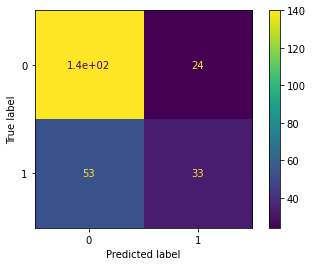

In [34]:
plot_confusion_matrix(mejor_modelo, x_test, y_test)  
plt.show()

Como puedes observar, el modelo tiende a predecir correctamente la clase 0, es decir, tiene mejor desempeño al predecir a las personas que no van a comprar un seguro de viaje. De hecho, para la clase 1, el modelo tiende a predecir erróneamente. Específicamente, podemos observar las siguientes métricas de desempeño para este problema:

* `accuracy_score` **(Exactitud):** mide la relación entre la cantidad de predicciones correctas y el total de datos.
* `recall_score` **(Sensibilidad):** indica cuántos datos de la clase positiva fueron clasificados correctamente (relaciona verdaderos positivos y falsos negativos).
* `precision_score` **(Precisión):** indica, de los datos clasificados en la clase positiva, cuántos son clasificados correctamente (relaciona verdaderos positivos y falsos positivos).
* `f1_score`**:** combina la precisión y la sensibilidad en una sola métrica.

In [35]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print('Sensibilidad: %.2f' % recall_score(y_test,y_pred))
print('Precisión: %.2f' % precision_score(y_test,y_pred))
print('F1-Score: %.2f' % f1_score(y_test,y_pred))

Exactitud: 0.69
Sensibilidad: 0.38
Precisión: 0.58
F1-Score: 0.46


Ten en cuenta que estas métricas se calculan, por defecto, sobre la clase positiva (la clase 1 en este problema). Sin embargo, todas las métricas se pueden calcular para cada clase, es decir, se puede asumir que una clase particular es positiva y que las demás son las clases negativas, obteniendo las métricas para todas las clases. Usando `scikit_learn`, podemos realizar este proceso usando la función `classification_report()`:

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       164
           1       0.58      0.38      0.46        86

    accuracy                           0.69       250
   macro avg       0.65      0.62      0.62       250
weighted avg       0.68      0.69      0.67       250



Para este modelo se tienen valores altos en la sensibilidad y precisión de la clase 0, lo que indica que tiene una alta probabilidad de detectar los datos de esta clase y de clasificarlos correctamente. Sin embargo, para la clase 1, la sensibilidad es tan solo del 0.38, lo que indica que este modelo no puede detectar muy bien a las personas que van a comprar un seguro de viaje. Ten en cuenta que, aún con este problema, la exactitud tiene un valor considerable de 0.69, pues la clase 0 es mayoritaria.

Dependiendo del problema que se quiere resolver, un modelo como este puede ser correcto o no. La regresión logística tiende a acomodarse a la clase mayoritaria, es decir, puede modelar de mejor manera la clase con mayor información. Sin embargo, muchos problemas reales tienen como objetivo la predicción de la clase minoritaria, por lo que es necesario realizar algún procedimiento para balancear el conjunto de datos, de forma que la cantidad de información disponible sea similar para todas las clases. Por ejemplo, se podría realizar un remuestreo de los datos, o escalar los coeficientes de acuerdo con la frecuencia de cada clase. 

Usando la clase `LogisticRegression()` podemos definir el parámetro `class_weight='balanced'`, que ajusta los coeficientes con el inverso de la frecuencia de cada clase. Definiremos un modelo con los mismos valores de hiperparámetros para el mejor modelo, pero adicionando el balanceo de clases:

In [37]:
log_bal = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced')
log_bal.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Con este modelo ajustado, realizaremos las predicciones sobre el mismo conjunto de pruebas:

In [38]:
y_pred = log_bal.predict(x_test)

Y graficaremos la matriz de confusión:

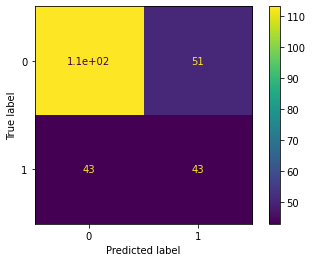

In [39]:
plot_confusion_matrix(log_bal, x_test, y_test)  
plt.show()

Finalmente, obtendremos las métricas de rendimiento para el modelo:

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.71       164
           1       0.46      0.50      0.48        86

    accuracy                           0.62       250
   macro avg       0.59      0.59      0.59       250
weighted avg       0.63      0.62      0.63       250



Puedes observar que la exactitud disminuyó con respecto al modelo original, pero la sensibilidad aumentó considerablemente para la clase 1, de 0.38 a 0.5. En general, debes tener en cuenta el contexto del problema para determinar qué clase es la de mayor interés y qué modificaciones debes realizar al modelo para que resuelva el problema correcto.

### Ejemplo de clasificación con el mejor modelo

Ahora veremos cómo se realiza una clasificación sobre un único dato. Empezaremos definiendo la variable `x_clasif` con uno de los valores del conjunto de test. Ten en cuenta que realizaremos nuestra predicción partiendo de la variable `x_test`, por lo que nuestro dato está codificado y estandarizado:

In [41]:
x_clasif = x_test.iloc[0]
x_clasif

Age                                             0.761248
AnnualIncome                                   -0.230174
FamilyMembers                                   0.629136
ChronicDiseases                                -0.715085
Employment Type_Government Sector               1.519193
Employment Type_Private Sector/Self Employed   -1.519193
GraduateOrNot_No                               -0.454447
GraduateOrNot_Yes                               0.454447
FrequentFlyer_No                                0.560780
FrequentFlyer_Yes                              -0.560780
EverTravelledAbroad_No                          0.492481
EverTravelledAbroad_Yes                        -0.492481
Name: 0, dtype: float64

Utilizaremos `predict_proba` para realizar la clasificación. Esta función necesita un arreglo de datos, por lo que pasaremos como parámetro un arreglo con una única posición. Almacenaremos el resultado en la variable `y_clasif`:

In [42]:
y_clasif = mejor_modelo.predict_proba([x_clasif])
y_clasif

array([[0.63716811, 0.36283189]])

Como puedes observar, el resultado de la predicción es un arreglo de predicciones, que en este caso solo tiene un elemento. El arreglo interno contiene dos posiciones, que representan las dos clases del problema. En regresión logística, la salida corresponde a la aplicación de la función sigmoide sobre el resultado de la combinación lineal de los coeficientes y el dato de entrada. Estos valores, a su vez, son estimaciones de la probabilidad de pertenencia del dato a cada clase, es decir, `x_clasif` tiene una probabilidad estimada de 0.637 de pertenecer a la clase 0, y una probabilidad estimada de 0.363 de pertenecer a la clase 1.

Si queremos obtener la clasificación de nuestro modelo, en vez de las estimaciones de probabilidad, podemos utilizar la función `argmax()` de `numpy`, que retorna el índice del arreglo con mayor valor. En ese sentido, estamos asignando la clase con mayor probabilidad a `x_clasif`:

In [43]:
np.argmax(y_clasif[0])

0

## 7. Almacenamiento y recuperación del mejor modelo

Finalmente, veremos cómo persistir los modelos creados con `scikit_learn` mediante la librería `joblib`, que nos permite almacenar objetos de Python en archivos. Esta librería está optimizada para almacenar objetos con gran cantidad de arreglos numéricos, como nuestro `mejor_modelo`. Primero crearemos el archivo con la función `dump()`, especificando el objeto a almacenar y el nombre del archivo (que tiene extensión `.joblib`):

In [44]:
joblib.dump(mejor_modelo, 'MejorModelo.joblib')

['MejorModelo.joblib']

Si queremos recuperar el modelo, utilizaremos la función `load()`, especificando como parámetro la ruta del archivo creado previamente:

In [45]:
modelo_final = joblib.load('MejorModelo.joblib')

Con el modelo cargado podemos, por ejemplo, realizar la clasificación del mismo dato que utilizamos anteriormente:

In [46]:
modelo_final.predict_proba([x_clasif])

array([[0.63716811, 0.36283189]])

## Cierre

En este tutorial hemos utilizado nuevas clases de scikit-learn para entrenar y evaluar modelos de clasificación usando regresión logística. Específicamente, observamos cómo codificar variables categóricas usando la codificación One Hot, realizamos una búsqueda exhaustiva de hiperparámetros y aplicamos una técnica básica de balanceo de clases. Finalmente, observamos cómo se realiza una clasificación y persistimos nuestro mejor modelo.

---
Si quieres más información sobre regresión logística en `scikit_learn` puedes consultar el [sitio web oficial](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Para la estandarización de datos con la clase `StandardScaler()` puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

Para la búsqueda de hiperparámetros con la clase `GridSearchCV()` puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Para obtener más información sobre las métricas de rendimiento para clasificación en `scikit_learn` puedes consultar: [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) y [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

Para obtener más información sobre el reporte de clasificación `classification_report()` puedes ir [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

Finalmente, para obtener más información sobre persistencia usando `joblib` puedes consultar el [sitio web oficial](https://joblib.readthedocs.io/en/latest/persistence.html)